In [21]:
from typing import List, Any
Shape = Any


In [22]:
from functools import lru_cache
import sys
import os
import glob

import dlib
from scipy.spatial import distance as dist
import cv2
from matplotlib import pyplot
import tqdm.notebook
import ipywidgets as wg
import IPython.core.display

HOME = os.environ['HOME']

In [23]:
# If this is broken then patch $VIRTUAL_ENV/lib/python3.7/site-packages/faced/detector.py
# as described in https://github.com/iitzco/faced/issues/27 and then:
#     del sys.modules["faced.detector"]
#     del sys.modules["faced"]
# so that it reloads when you import it again.
import faced


In [24]:
predictor_path = 'shape_predictor_68_face_landmarks.dat'
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor(predictor_path)


In [25]:
@lru_cache(maxsize=1000_000)
def detect(filename) -> List[Shape]:
    img = dlib.load_rgb_image(filename)
    dets = detector(img, 1)
    shapes = []
    for d in dets:
        shape = predictor(img, d)
        shapes.append(shape)
    return shapes


In [26]:


face_detector = faced.FaceDetector()

def to_rectangles(bboxes):
    rectangles = dlib.rectangles()
    for (x_center, y_center, width, height, prob) in bboxes:
        rectangle = dlib.rectangle(
            x_center - (width//2),
            y_center - (height//2),
            x_center + (width//2),
            y_center + (height//2),
        )
        rectangles.append(rectangle)
    return rectangles

@lru_cache(maxsize=1000_000)
def detect_both_ways(filename):
    img = dlib.load_rgb_image(filename)
    dets = detector(img, 1)

    img = cv2.imread(filename)
    rgb_img = cv2.cvtColor(img.copy(), cv2.COLOR_BGR2RGB)

    # Receives RGB numpy image (HxWxC) and
    # returns (x_center, y_center, width, height, prob) tuples. 
    bboxes = face_detector.predict(rgb_img)
    return dets, to_rectangles(bboxes)



@lru_cache(maxsize=1000_000)
def detect2(filename):
    img = cv2.imread(filename)
    rgb_img = cv2.cvtColor(img.copy(), cv2.COLOR_BGR2RGB)
    bboxes = face_detector.predict(rgb_img)
    rectangles = to_rectangles(bboxes)
    faces = []
    for d in rectangles:
        face = predictor(img, d)
        if valid(face, img.shape):
            faces.append(face)
    return faces

In [125]:
# see https://www.learnopencv.com/face-detection-opencv-dlib-and-deep-learning-c-python/
import cv2
import time
import sys


def detectFaceOpenCVDnn(net, frame):
    conf_threshold = 0.8
    
    frameOpencvDnn = frame.copy()
    frameHeight = frameOpencvDnn.shape[0]
    frameWidth = frameOpencvDnn.shape[1]
    blob = cv2.dnn.blobFromImage(frameOpencvDnn, 1.0, (300, 300), [104, 117, 123], False, False)

    net.setInput(blob)
    detections = net.forward()
    bboxes = []
    for i in range(detections.shape[2]):
        confidence = detections[0, 0, i, 2]
        if confidence > conf_threshold:
            x1 = int(detections[0, 0, i, 3] * frameWidth)
            y1 = int(detections[0, 0, i, 4] * frameHeight)
            x2 = int(detections[0, 0, i, 5] * frameWidth)
            y2 = int(detections[0, 0, i, 6] * frameHeight)
            bboxes.append((confidence, [x1, y1, x2, y2]))
            cv2.rectangle(frameOpencvDnn, (x1, y1), (x2, y2), (0, 255, 0), int(round(frameHeight/150)), 8)
    return frameOpencvDnn, bboxes

@lru_cache()
def initOpenCVDnn():
    modelFile = "learnopencv/FaceDetectionComparison/models/res10_300x300_ssd_iter_140000_fp16.caffemodel"
    configFile = "learnopencv/FaceDetectionComparison/models/deploy.prototxt"
    net = cv2.dnn.readNetFromCaffe(configFile, modelFile)
    
    return net

@lru_cache(maxsize=1000_000)
def detect_dnn_with_scores(filename):
    net = initOpenCVDnn()
    img = cv2.imread(filename)
#     rgb_img = cv2.cvtColor(img.copy(), cv2.COLOR_BGR2RGB)
    outOpencvDnn, bboxes = detectFaceOpenCVDnn(net,img)
    
    faces = []
    for score, bbox in bboxes:
        face = predictor(img, dlib.rectangle(*bbox))
        if valid(face, img.shape):
            faces.append((score, face))
    return faces


def detect_dnn(filename):
    return [face for (_, face) in detect_dnn_with_scores(filename)]

In [81]:
def valid(face, shape=(1920, 3840, 3)):
    y, x, *_channels = shape
    return any((point.x < x and point.y < y) for point in face.parts())

def only_valid(faces, shape=(1920, 3840, 3)):
    return [
        face for face in faces
        if valid(face, shape)
    ]

def only_invalid(faces, shape=(1920, 3840, 3)):
    return [
        face for face in faces
        if not valid(face, shape)
    ]

In [123]:
def detect_with_fallbacks(filename):
    return detect_dnn(filename) # or detect2(filename) # or detect(filename)

In [29]:
FACIAL_LANDMARKS_IDXS = dict([
    ("mouth", (48, 68)),
    ("right_eyebrow", (17, 22)),
    ("left_eyebrow", (22, 27)),
    ("right_eye", (36, 42)),
    ("left_eye", (42, 48)),
    ("nose", (27, 35)),
    ("jaw", (0, 17))
])


def eye_aspect_ratio(eye):
    # compute the euclidean distances between the two sets of
    # vertical eye landmarks (x, y)-coordinates
    A =  dlib.length(eye[1] - eye[5])
    B =  dlib.length(eye[2] - eye[4])
 
    # compute the euclidean distance between the horizontal
    # eye landmark (x, y)-coordinates
    C = dlib.length(eye[0] - eye[3])
 
    # compute the eye aspect ratio
    ratio = (A + B) / (2.0 * C)
 
    # return the eye aspect ratio
    return ratio

def max_eye_aspect_ratio(faces):
    max_ratio = 0
    for face in faces:
        for part in ("left_eye", "right_eye"):
            start, end = FACIAL_LANDMARKS_IDXS[part]
            eye = face.parts()[start:end]
            ratio = eye_aspect_ratio(eye)
            max_ratio = max([ratio, max_ratio])
    return max_ratio

def eye_score_for_file(filename):
    return max_eye_aspect_ratio(detect_with_fallbacks(filename))

def max_face_size(faces):
    max_size = 0
    for face in faces:
        parts = face.parts()
        size = 0
        size += dlib.length(parts[1] - parts[17])
        size += dlib.length(parts[2] - parts[16])
        size += dlib.length(parts[3] - parts[15])
        max_size = max([size, max_size])
    return max_size

def face_score_for_file(filename):
    return max_face_size(detect_with_fallbacks(filename))
    

In [165]:
@lru_cache(maxsize=1000_000)
def save_face_chip(filename):
    faces = detect_with_fallbacks(filename)
    if not len(faces):
        return filename

    img = dlib.load_rgb_image(filename)
    faces = only_valid(faces, img.shape)
    if not len(faces):
        return filename
    scores = [max_eye_aspect_ratio([face]) for face in faces]

    best_face = max(zip(scores, enumerate(faces)))[-1][-1]
    
    for part in ("left_eye", "right_eye"):
        start, end = FACIAL_LANDMARKS_IDXS[part]
        eye = best_face.parts()[start:end]
        for pointa, pointb in zip(eye, list(eye[1:])+list(eye[:1])):
            cv2.line(img, (pointa.x, pointa.y),(pointb.x, pointb.y), (255,0,255), 5)
#     dlib.save_image(img, filename.replace('.jpeg', '.detected.jpg'))
    dlib.save_face_chip(img, best_face, filename.replace('.jpeg', '.detected'))
    return filename.replace('.jpeg', '.detected.jpg')


In [157]:
cv2.line?

In [31]:
@lru_cache(maxsize=1000_000)
def save_broken_face_chip(filename):
    faces = only_invalid(detect_with_fallbacks(filename))
    scores = [max_eye_aspect_ratio([face]) for face in faces]
    if len(faces):
        best_face = max(zip(scores, enumerate(faces)))[-1][-1]
        img = dlib.load_rgb_image(filename)
        dlib.save_face_chip(img, best_face, filename.replace('.jpeg', '.funky'))
        return filename.replace('.jpeg', '.funky.jpg')
    return filename

In [126]:
faces_folder_path = f'{HOME}/tmp/*x*/*/*.mp4.images/'

files = list(
    f for f in sorted(glob.glob(os.path.join(faces_folder_path, "*.jpeg")))
    if '/tmp/3840x1920/1.mp4' not in f
#     and '1920x1080/1080P_4000K_236777331.mp4' in f
)

for filename in tqdm.notebook.tqdm(files): #[126:][:1]:
#     print("Processing file: {}".format(filename))
    shapes = detect_with_fallbacks(filename)
    if len(shapes):
#         print(len(shapes), max_eye_aspect_ratio(shapes))
#         continue
        save_face_chip(filename)
        


In [176]:
face_filenames = list(
    sorted(
        [
            filename for filename in files
            if True
            and ('1920x1080'  in filename)
            and 0.5 > eye_score_for_file(filename) > 0.25 

#             and '1920x1080/1080P_4000K_236777331.mp4' in filename
#             and only_invalid(detect_with_fallbacks(filename))
        ],
#         key=face_score_for_file,
    )
)

def show_face(x):
    filename = face_filenames[x]
    facename = filename.replace('.jpeg', '.detected')
    shapes = detect_with_fallbacks(filename)
    print(len(shapes), len(detect(filename)), filename.replace(HOME, '~'))
    print(eye_score_for_file(filename))
    print(face_score_for_file(filename))
    
    if len(shapes):
        print([s for (s,_) in detect_dnn_with_scores(filename)])
        filename = save_face_chip(filename)
    widget = IPython.core.display.Image(filename=filename)
    return widget

maxf = len(face_filenames) - 1
wg.interact(show_face, x=wg.IntSlider(min=1,max=maxf,step=1));


interactive(children=(IntSlider(value=1, description='x', max=350, min=1), Output()), _dom_classes=('widget-in…

In [63]:
len(face_filenames) , len(files)

(467, 906)

In [64]:
len(face_filenames) , len(files)

(467, 906)

In [65]:
len(face_filenames) , len(files)

(467, 906)

In [172]:
from collections import Counter
totals_breakdown = Counter(filename.split('keyframe')[0] for filename in files)
# totals_breakdown

In [173]:
faces_breakdown = Counter(filename.split('keyframe')[0] for filename in face_filenames)
# faces_breakdown

In [174]:
best = sorted([(faces_breakdown[k]/totals_breakdown[k], k.replace('.images/', '.hls/out.m3u8').replace(HOME, '~')) for k in totals_breakdown.keys()], reverse=True)
best

[(0.47058823529411764,
  '~/tmp/1920x1080/aa/1080P_4000K_266689892.mp4.hls/out.m3u8'),
 (0.4357142857142857,
  '~/tmp/1920x1080/aa/1080P_4000K_268373792.mp4.hls/out.m3u8'),
 (0.39375, '~/tmp/1920x1080/aa/1080P_4000K_258650292.mp4.hls/out.m3u8'),
 (0.3812154696132597,
  '~/tmp/1920x1080/aa/1080P_4000K_261876322.mp4.hls/out.m3u8'),
 (0.3708609271523179,
  '~/tmp/1920x1080/aa/1080P_4000K_260238242.mp4.hls/out.m3u8'),
 (0.2967741935483871,
  '~/tmp/1920x1080/aa/1080P_4000K_269839451.mp4.hls/out.m3u8'),
 (0.0, '~/tmp/1280x720/Beertje96/720P_4000K_128359601.mp4.hls/out.m3u8')]

In [175]:
import os

def to_keyframe_filename(ts_filename):
    return ts_filename.replace(
        'segment', 'keyframe'
    ).replace(
        '.ts\n', '.jpeg'
    )

def make_filtered_playlist(
    original_playlist_filename,
    filter_function,
    output_filename='filtered.m3u8',
):
    out = []
    chunks: Tuple[str, str] = []
    chunk_start: Optional[str] = None
    with open(original_playlist_filename) as f:
    
        lines = iter(f)
        for line in lines:
            if line.startswith('#EXTINF'):
                chunk_start = line
                break
            out.append(line)

        for line in lines:
            if chunk_start is not None:
                chunks.append((chunk_start, line))
                chunk_start = None
            elif line.startswith('#EXTINF'):
                chunk_start = line
            else:
                # really I should use a peekable iterator, or put line back on
                # the front of lines, but nevermind.
                trailing_line = line
                break
        else:
            trailing_line = ''

        chunks = [
            chunk
            for chunk in chunks
            if filter_function(
                original_playlist_filename.replace(
                    '.hls/out.m3u8', 
                    '.images/' + to_keyframe_filename(chunk[-1])
                )
            )
        ]

        for chunk in chunks:
            out.extend(chunk)
            # Credit to @DHE in #ffmpeg on freenode for suggesting
            # #EXT-X-DISCONTINUITY.
            # https://developer.apple.com/documentation/http_live_streaming/example_playlists_for_http_live_streaming/incorporating_ads_into_a_playlist
            out.append('#EXT-X-DISCONTINUITY\n')
        # strip the #EXT-X-DISCONTINUITY from after the last chunk
        out.pop()
        out.append(trailing_line)

        for line in lines:
            out.append(line)

    filtered_filename = original_playlist_filename.replace('out.m3u8', output_filename)
    with open(filtered_filename,'w',) as f:
        f.write(''.join(out)+'\n')
    return filtered_filename.replace(HOME, '~')
        

def has_eye_contact(filename):
    if not os.path.exists(filename):
        return False
    return 0.5 > eye_score_for_file(filename) > 0.25

def has_no_eye_contact(filename):
    if not os.path.exists(filename):
        return False
    return eye_score_for_file(filename) < 0.25

for _score, filename in best:
    print(make_filtered_playlist(
        filename.replace('~', HOME),
        has_eye_contact,
        'filtered.m3u8'
    ))
    print(make_filtered_playlist(
        filename.replace('~', HOME),
        has_no_eye_contact,
        'rejected.m3u8'
    ))

~/tmp/1920x1080/aa/1080P_4000K_266689892.mp4.hls/filtered.m3u8
~/tmp/1920x1080/aa/1080P_4000K_266689892.mp4.hls/rejected.m3u8
~/tmp/1920x1080/aa/1080P_4000K_268373792.mp4.hls/filtered.m3u8
~/tmp/1920x1080/aa/1080P_4000K_268373792.mp4.hls/rejected.m3u8
~/tmp/1920x1080/aa/1080P_4000K_258650292.mp4.hls/filtered.m3u8
~/tmp/1920x1080/aa/1080P_4000K_258650292.mp4.hls/rejected.m3u8
~/tmp/1920x1080/aa/1080P_4000K_261876322.mp4.hls/filtered.m3u8
~/tmp/1920x1080/aa/1080P_4000K_261876322.mp4.hls/rejected.m3u8
~/tmp/1920x1080/aa/1080P_4000K_260238242.mp4.hls/filtered.m3u8
~/tmp/1920x1080/aa/1080P_4000K_260238242.mp4.hls/rejected.m3u8
~/tmp/1920x1080/aa/1080P_4000K_269839451.mp4.hls/filtered.m3u8
~/tmp/1920x1080/aa/1080P_4000K_269839451.mp4.hls/rejected.m3u8
~/tmp/1280x720/Beertje96/720P_4000K_128359601.mp4.hls/filtered.m3u8
~/tmp/1280x720/Beertje96/720P_4000K_128359601.mp4.hls/rejected.m3u8


In [139]:
faces = [
    (filename, face)
    for filename in face_filenames
#         if ('1920x1080/1080P_4000K_236777331.mp4' in filename)
            for face in detect_with_fallbacks(filename)
#                 if not any((point.x < 1920 and point.y < 1080) for point in face.parts())
]


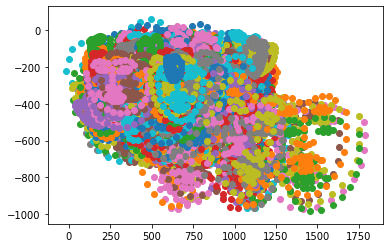

In [140]:
pyplot.figure()
for filename, face in faces:
    points = [
        (point.x, -point.y)
        for point in face.parts()
    ]
    pyplot.scatter(*zip(*points), label=filename.replace(HOME, '~'))
# pyplot.legend()

No handles with labels found to put in legend.


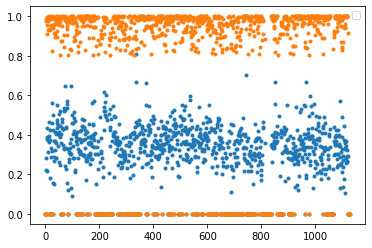

In [149]:
pyplot.figure()
eyes = [
    (
        eye_score_for_file(filename),
        max((i for (i, _) in detect_dnn_with_scores(filename)), default=0)
    )
    for (i, filename) in enumerate(files)
    if 'Beertje96' in filename
]
pyplot.plot(eyes, linestyle='', marker='.')
pyplot.legend()

In [147]:
pyplot.plot?


In [142]:
max?

In [179]:
len(face.parts())


68